In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
batch_size = 40
img_height = 200
img_width = 200

Keras dataset preprocessing utilities, located at tf.keras.preprocessing, help you go from raw data on disk to a tf.data.Dataset object that can be used to train a model.

See https://keras.io/api/preprocessing/

Once the dataset is preprocessed and loaded, it can be directly used in calls to model.fit



In [3]:
## loading training data
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/MaskNoMask/data',
    validation_split=0.2,
    subset= "training",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

Found 7553 files belonging to 2 classes.
Using 6043 files for training.


In [4]:
## loading testing data
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
'data/MaskNoMask/data',
    validation_split=0.2,
    subset= "validation",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

Found 7553 files belonging to 2 classes.
Using 1510 files for validation.


In [5]:
training_ds

<BatchDataset shapes: ((None, 200, 200, 3), (None,)), types: (tf.float32, tf.int32)>

In [6]:
class_names = training_ds.class_names

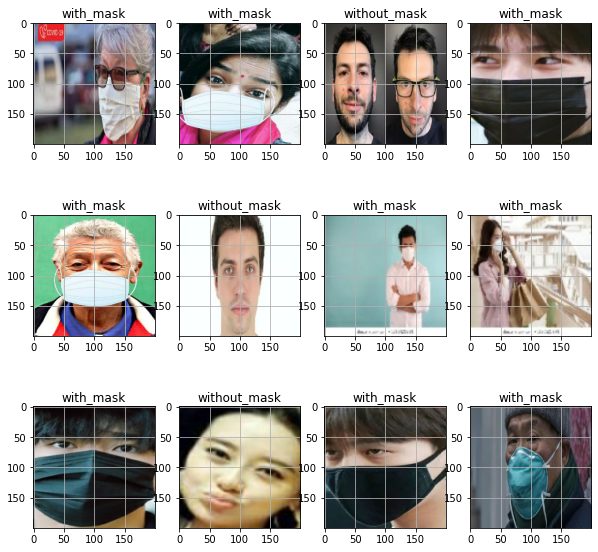

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.grid(True)

In [8]:
from keras.models import Model
from keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50
from keras import applications
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [9]:
## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Now build a deep neural network and train it and see how you do

Starting with examples from keras docs found here
 
 https://keras.io/examples/vision/image_classification_from_scratch/

In [10]:
inputs = Input(shape=(200, 200, 3))

x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(64, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

previous_block_activation = x  # Set aside residual

for size in [128, 256, 512, 728]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(size, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

x = layers.SeparableConv2D(1024, 3, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.GlobalAveragePooling2D()(x)
activation = "sigmoid"
units = 1

x = layers.Dropout(0.5)(x)
outputs = layers.Dense(units, activation=activation)(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 100, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 100, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 100, 100, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [12]:
model.compile(
    optimizer=Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    training_ds, epochs=3, validation_data=testing_ds,
)

Epoch 1/3
152/152 [==============================] - 83s 546ms/step - loss: 0.2543 - accuracy: 0.8934 - val_loss: 0.7271 - val_accuracy: 0.5086
Epoch 2/3
152/152 [==============================] - 73s 483ms/step - loss: 0.1303 - accuracy: 0.9482 - val_loss: 0.6115 - val_accuracy: 0.6272
Epoch 3/3
152/152 [==============================] - 74s 484ms/step - loss: 0.0873 - accuracy: 0.9667 - val_loss: 0.3695 - val_accuracy: 0.8477


In [13]:
model.fit(
    training_ds, epochs=3, validation_data=testing_ds,
)

Epoch 1/3
152/152 [==============================] - 74s 484ms/step - loss: 0.0739 - accuracy: 0.9724 - val_loss: 0.2641 - val_accuracy: 0.9358
Epoch 2/3
152/152 [==============================] - 75s 492ms/step - loss: 0.0457 - accuracy: 0.9823 - val_loss: 0.0964 - val_accuracy: 0.9689
Epoch 3/3
152/152 [==============================] - 73s 481ms/step - loss: 0.0288 - accuracy: 0.9907 - val_loss: 0.1752 - val_accuracy: 0.9424
